(3000, 3)

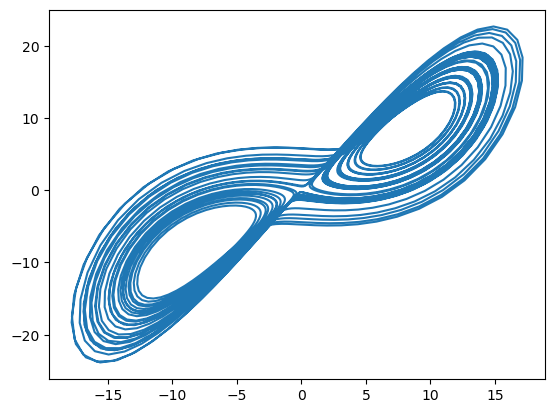

In [3]:
# in this notebook we're going to make sure the dynamic quantities are correct by evaluating them on two different
# versions of a particular chaotic attractor: delay embedded reconstruction or high dimensional embedding with linear layers

import matplotlib.pyplot as plt
import numpy as np
from dysts.flows import Lorenz

## Load and simulate an attractor
attractor = Lorenz()
sol = attractor.make_trajectory(3000, resample=True, noise=0.0)
sol += np.random.random(sol.shape) * 0.0
plt.figure()
plt.plot(sol[:, 0], sol[:, 1])
# sol = sol[::10]
sol.shape

(3000, 3)

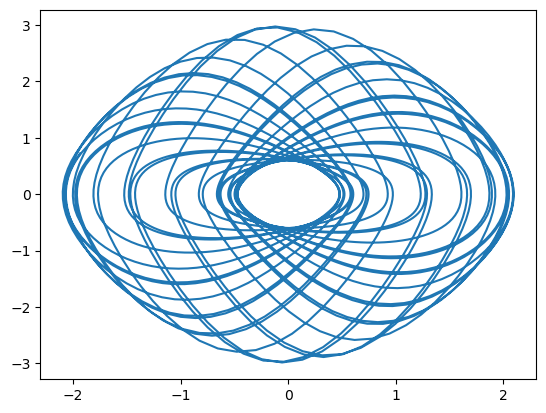

In [4]:
from dysts.flows import SprottA as Null

null = Null()
null_sol = null.make_trajectory(3000, resample=True, noise=0.0)
null_sol += np.random.random(null_sol.shape) * 0.0

plt.figure()
plt.plot(null_sol[:, 0], null_sol[:, 1])
null_sol.shape

In [5]:
x = sol[:, 0]

n_delays = 10
delay_interval = 1

# create delay embedding
H = np.array(
    [
        x[i : i + n_delays * delay_interval : delay_interval]
        for i in range(x.shape[0] - n_delays * delay_interval)
    ]
)

print(H.shape)
# embed the full sol into much higher dimensions with a random project
embed_dim = 10

# random projection
W = np.random.randn(embed_dim, sol.shape[1])

E = sol @ W.T

E.shape

(2990, 10)


(3000, 10)

Text(0.5, 0.92, 'High dimensional embedding')

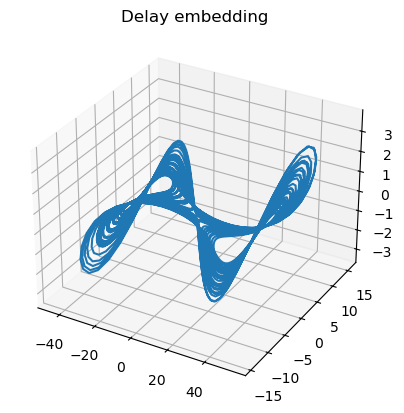

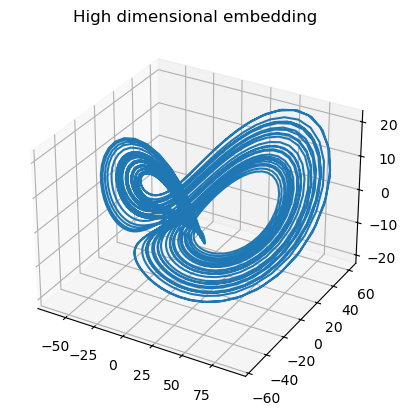

In [6]:
# plot top 3 dimensions of the delay embedding after PCA
from sklearn.decomposition import PCA

H_red = PCA(n_components=3).fit_transform(H)


# plot in 3d
plt.figure()
ax = plt.axes(projection="3d")
ax.plot3D(H_red[:, 0], H_red[:, 1], H_red[:, 2])
plt.title("Delay embedding")

# do the same with E
E_red = PCA(n_components=3).fit_transform(E)
plt.figure()
ax = plt.axes(projection="3d")
ax.plot3D(E_red[:, 0], E_red[:, 1], E_red[:, 2])
plt.title("High dimensional embedding")

In [7]:
# compute the dynamic quantities and compare to actual lorenz
import sys

sys.path.append("..")

from src.metrics import (
    neighbors_comparison,
    gp_diff_asym,
)

In [6]:
H_overlap, H_corr = neighbors_comparison(sol[n_delays:], H, n_neighbors=100)

E_overlap, E_corr = neighbors_comparison(sol, E, n_neighbors=100)

print(H_overlap, H_corr)
print(E_overlap, E_corr)

TypeError: cannot unpack non-iterable numpy.float64 object

In [8]:
gpdist_H = gp_diff_asym(sol[np.newaxis, n_delays:], H[np.newaxis])
gpdist_E = gp_diff_asym(sol[np.newaxis], E[np.newaxis])
print(gpdist_H, gpdist_E)

[0.16804867] [2.0412095e-07]


In [7]:
H.shape, E.shape

((2990, 10), (3000, 10))

In [8]:
# whiten H, sol, E, null_sol first

from sklearn.preprocessing import StandardScaler

H = StandardScaler().fit_transform(H)
E = StandardScaler().fit_transform(E)
sol = StandardScaler().fit_transform(sol)
null_sol = StandardScaler().fit_transform(null_sol)
print(np.mean(H), np.std(H))

1.0646259050853675e-16 0.9999999999999999


In [9]:
from DSA import DSA

pca_dim = None
delays = 10

rank = 30

if pca_dim is not None:

    def reduce(x, n_components):
        pca = PCA(n_components=n_components)
        d = x.reshape(-1, x.shape[-1])
        red = pca.fit_transform(d)
        x = red.reshape(x.shape[0], n_components)
        return x

    h1 = reduce(H, pca_dim)
    h2 = reduce(E, pca_dim)
    h1 = h1
    h2 = h2
else:
    h1 = H
    h2 = E

s = sol
from sklearn.gaussian_process.kernels import RBF

score_method = "euclidean"
wasserstein_compare = None


dsa1 = DSA(
    s,
    h1,
    n_delays=delays,
    delay_interval=1,
    rank=rank,
    device="cuda",
    iters=1000,
    lr=0.01,
    score_method=score_method,
    wasserstein_compare=wasserstein_compare,
)
print(dsa1.dmds[0][0].data.shape, dsa1.dmds[1][0].data.shape)
score1 = dsa1.fit_score()

dsa2 = DSA(
    s,
    h2,
    n_delays=delays,
    delay_interval=1,
    rank=rank,
    device="cuda",
    iters=1000,
    lr=0.01,
    score_method=score_method,
    wasserstein_compare=wasserstein_compare,
)
score2 = dsa2.fit_score()

dsa_null1 = DSA(
    h1,
    null_sol,
    n_delays=delays,
    delay_interval=1,
    rank=rank,
    device="cuda",
    iters=1000,
    lr=0.01,
    score_method=score_method,
    wasserstein_compare=wasserstein_compare,
)
score_null1 = dsa_null1.fit_score()

dsa_null2 = DSA(
    s,
    null_sol,
    n_delays=delays,
    delay_interval=1,
    rank=rank,
    device="cuda",
    iters=1000,
    lr=0.01,
    score_method=score_method,
    wasserstein_compare=wasserstein_compare,
)
score_null2 = dsa_null2.fit_score()


print(score1, score2, score_null1, score_null2)

torch.Size([3000, 3]) torch.Size([2990, 10])
0.4324132204055786 0.06553816795349121 0.463325560092926 0.1224680244922638


In [16]:
sol.shape, h1.shape, null_sol.shape

((3000, 3), (2990, 10), (3000, 3))

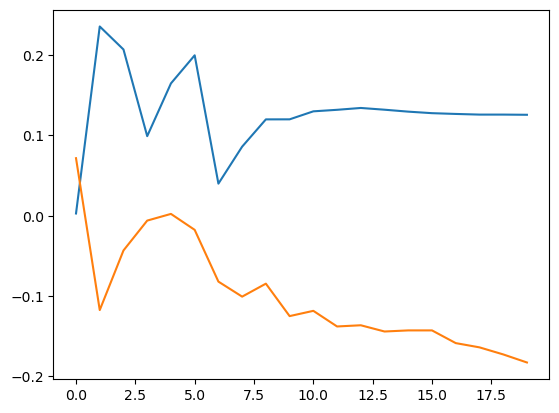

In [17]:
# testing skccm on thisdata
from skccm import CCM
from skccm.utilities import train_test_split

# x1tr, x1te, x2tr, x2te = train_test_split(sol[:-n_delays],h1, percent=.75)
x1tr, x1te, x2tr, x2te = train_test_split(sol, null_sol, percent=0.75)

ccm = CCM()  # initiate the class

# library lengths to test
len_tr = len(x1tr)
lib_lens = np.arange(10, len_tr, len_tr / 20, dtype="int")

# test causation
ccm.fit(x1tr, x2tr)
x1p, x2p = ccm.predict(x1te, x2te, lib_lengths=lib_lens)

sc1, sc2 = ccm.score()
plt.plot(sc1)
plt.plot(sc2)